# Tutorial

**What will be covered in this tutorial?**

This tutorial will go through the different tools Monkeybread provides, what they do, and how to use them. Monkeybread's tools focus on cell proximity in spatial data, allowing for an additional layer of analysis over regular single-cell data.

**What data does this tutorial use?**

This tutorial uses data from Vizgen's [MERSCOPE FFPE data release](https://info.vizgen.com/ffpe-showcase), in particular one of the Ovarian Cancer samples. Due to the large size of transcript and cell boundary files, the smallest sample was selected for the tutorial.
> Note: Accessing the dataset in this tutorial requires the `gsutil` command-line tool. Learn more and install [here](https://cloud.google.com/storage/docs/gsutil_install)

**What does the data look like?**

The data for each sample is split up across a few different files. `cell_by_gene.csv` is the standard file containing cells as rows and genes as columns. `cell_metadata.csv` contains additional information for cells relating to spatial data, namely x-y coordinates for each cell (min, center, and max). These files are both preprocessed. To access more raw data, we can examine the `cell_bounds/` folder and `detected_transcripts.csv`. The former contains many files, named `feature_data_{fov}.hdf5`, corresponding to the `fov` column in `cell_metadata.csv`. These hdf5 files contain boundary coordinates for each cell, giving a less boxy outline than provided in the processed data. `detected_transcripts.csv` contains transcripts in each row with their respective x-y coordinates, which are then assigned to cells based on the cell boundaries.

In [1]:
import monkeybread as mb
import scanpy as sc
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
import matplotlib as mpl

sc.settings.verbosity = 3

In [2]:
# Use gsutil to download the data from Google Cloud where the public data is stored
subprocess.run(
    "mkdir data",
    shell = True
)
subprocess.run(
    "gsutil -m cp -n gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_by_gene.csv \
    gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_metadata.csv \
    ./data/",
    shell = True
)

CompletedProcess(args='gsutil -m cp -n gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_by_gene.csv     gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_metadata.csv     ./data/', returncode=0)

In [3]:
# OPTIONAL: To use cell_transcript_proximity functions
subprocess.run(
    "gsutil -m cp -r -n gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/detected_transcripts.csv \
    gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_boundaries/ \
    ./data/",
    shell = True
)

CompletedProcess(args='gsutil -m cp -r -n gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/detected_transcripts.csv     gs://vz-ffpe-showcase/HumanOvarianCancerPatient2Slice2/cell_boundaries/     ./data/', returncode=0)

In [4]:
# No need to specify custom file paths, this function will read in all relevant files in the directory provided.
adata = mb.util.load_merscope("./data")

... reading from cache file cache\data-cell_by_gene.h5ad


C:\Users\Dillon Scott\monkeybread\venv\lib\site-packages\monkeybread\util\_load_merscope.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs["bounds"][cell_id] = np.array(f[


Perform some standard preprocessing on the data.

In [5]:
sc.pp.filter_cells(adata, min_counts = 50, inplace = True)
sc.pp.normalize_total(adata, target_sum = 1000000, inplace = True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added = "clusters")

filtered out 6770 cells that have less than 50 counts
normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)
running Leiden clustering
    finished: found 11 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:21)


Visualize the data using UMAP embedding of the gene expression data as well as the spatial coordinates of each cell.

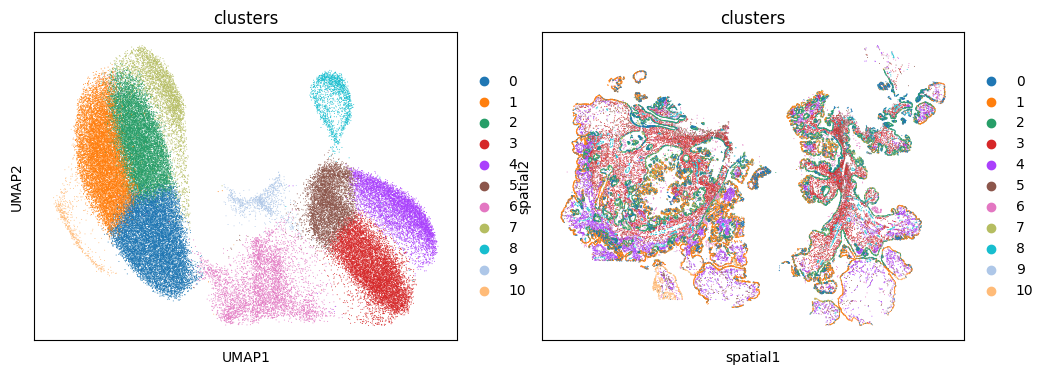

In [6]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
sc.pl.embedding(
    adata,
    "umap",
    color = "clusters",
    ax = axs[0],
    show = False
)
sc.pl.embedding(
    adata,
    "spatial",
    color = "clusters",
    ax = axs[1],
    show = True
)

## Cell Proximity Analyses

Monkeybread provides several ways to investigate cell proximity in spatial data.

### Kernel Density Estimation

We can plot the density of cells with a specific label (e.g., cell type or cluster) across the cell using kernel density estimation ([KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation)). Due to the high number of cells, Monkeybread uses an approximate KDE on groups cells set by the `resolution` parameter. In the limit, a higher resolution will produce the results of standard KDE.

C:\Users\Dillon Scott\monkeybread\venv\lib\site-packages\monkeybread\calc\_kernel_density.py:72: RuntimeWarning: overflow encountered in exp
  kernel = 1 / np.exp(np.square(distances / bandwidth))


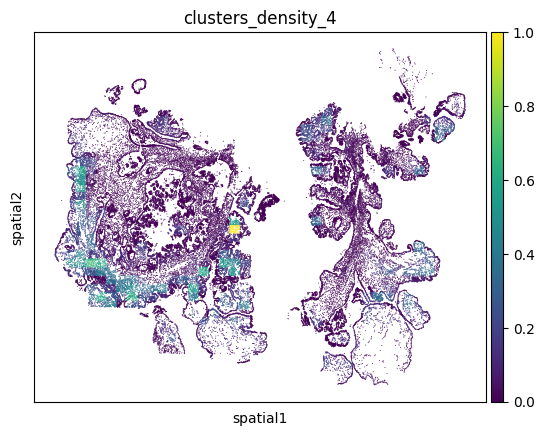

In [7]:
density_key = mb.calc.kernel_density(
    adata,
    groupby = "clusters",
    group = "4",
    resolution = 4
)
mb.plot.kernel_density(
    adata,
    key = density_key
)

### Shortest Distances

Monkeybread enables the analysis of distances between cells of two groups. Below, we plot the distribution of shortest distances over each cell of `group1` to its nearest neighbor in `group2`.

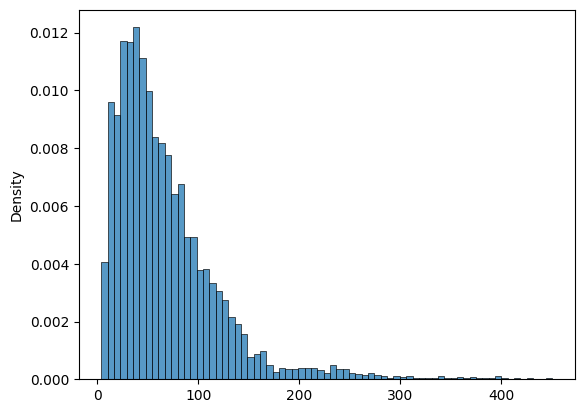

In [8]:
distances = mb.calc.shortest_distances(
    adata,
    groupby = "clusters",
    group1 = "4",
    group2 = ["9", "10"]
)
mb.plot.shortest_distances(distances)

A permutation test can be used to test whether the number of cells in `group1` that are within threshold distance of cells in `group2` is what we would expect by chance. This permutation test generates a null distribution by permuting the cell labels and then computing a p-value representing the probability of observing at least the observed number in `group1` within threshold distance of `group2` under permutation. The red vertical bar shows the upper limit of the threshold.

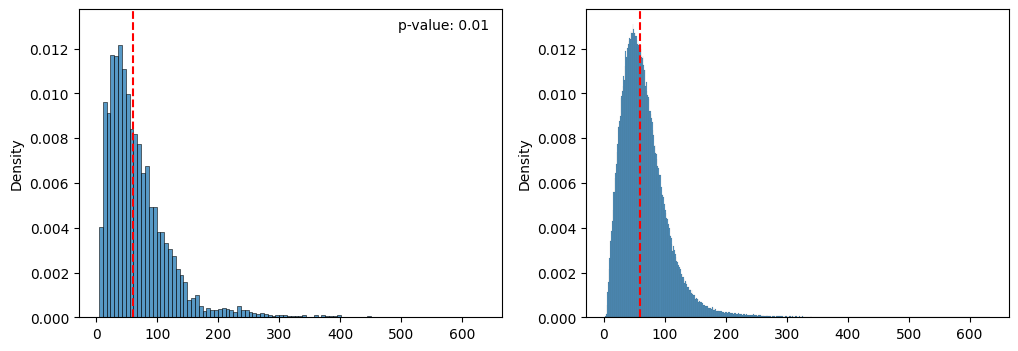

In [9]:
permutation_distances = mb.stat.shortest_distances(
    adata,
    groupby = "clusters",
    group1 = "4",
    group2 = ["9", "10"],
    actual = distances,
    threshold = 60
)
mb.plot.shortest_distances(distances, expected_distances = permutation_distances)

### Cell Contact

Monkeybread's `cell_contact` function computes the number of cells in one group of cells that are "in contact" (i.e., within a specified radius) with cells in another group. If radius is not specified, it can be inferred using width and height for each cell. The `cell_contact_embedding` function will highlight cells in the two groups that are in contact. The `cell_contact_heatmap` will display the number of cells in `group1` (rows) that are in contact with cells in `group2` (columns)

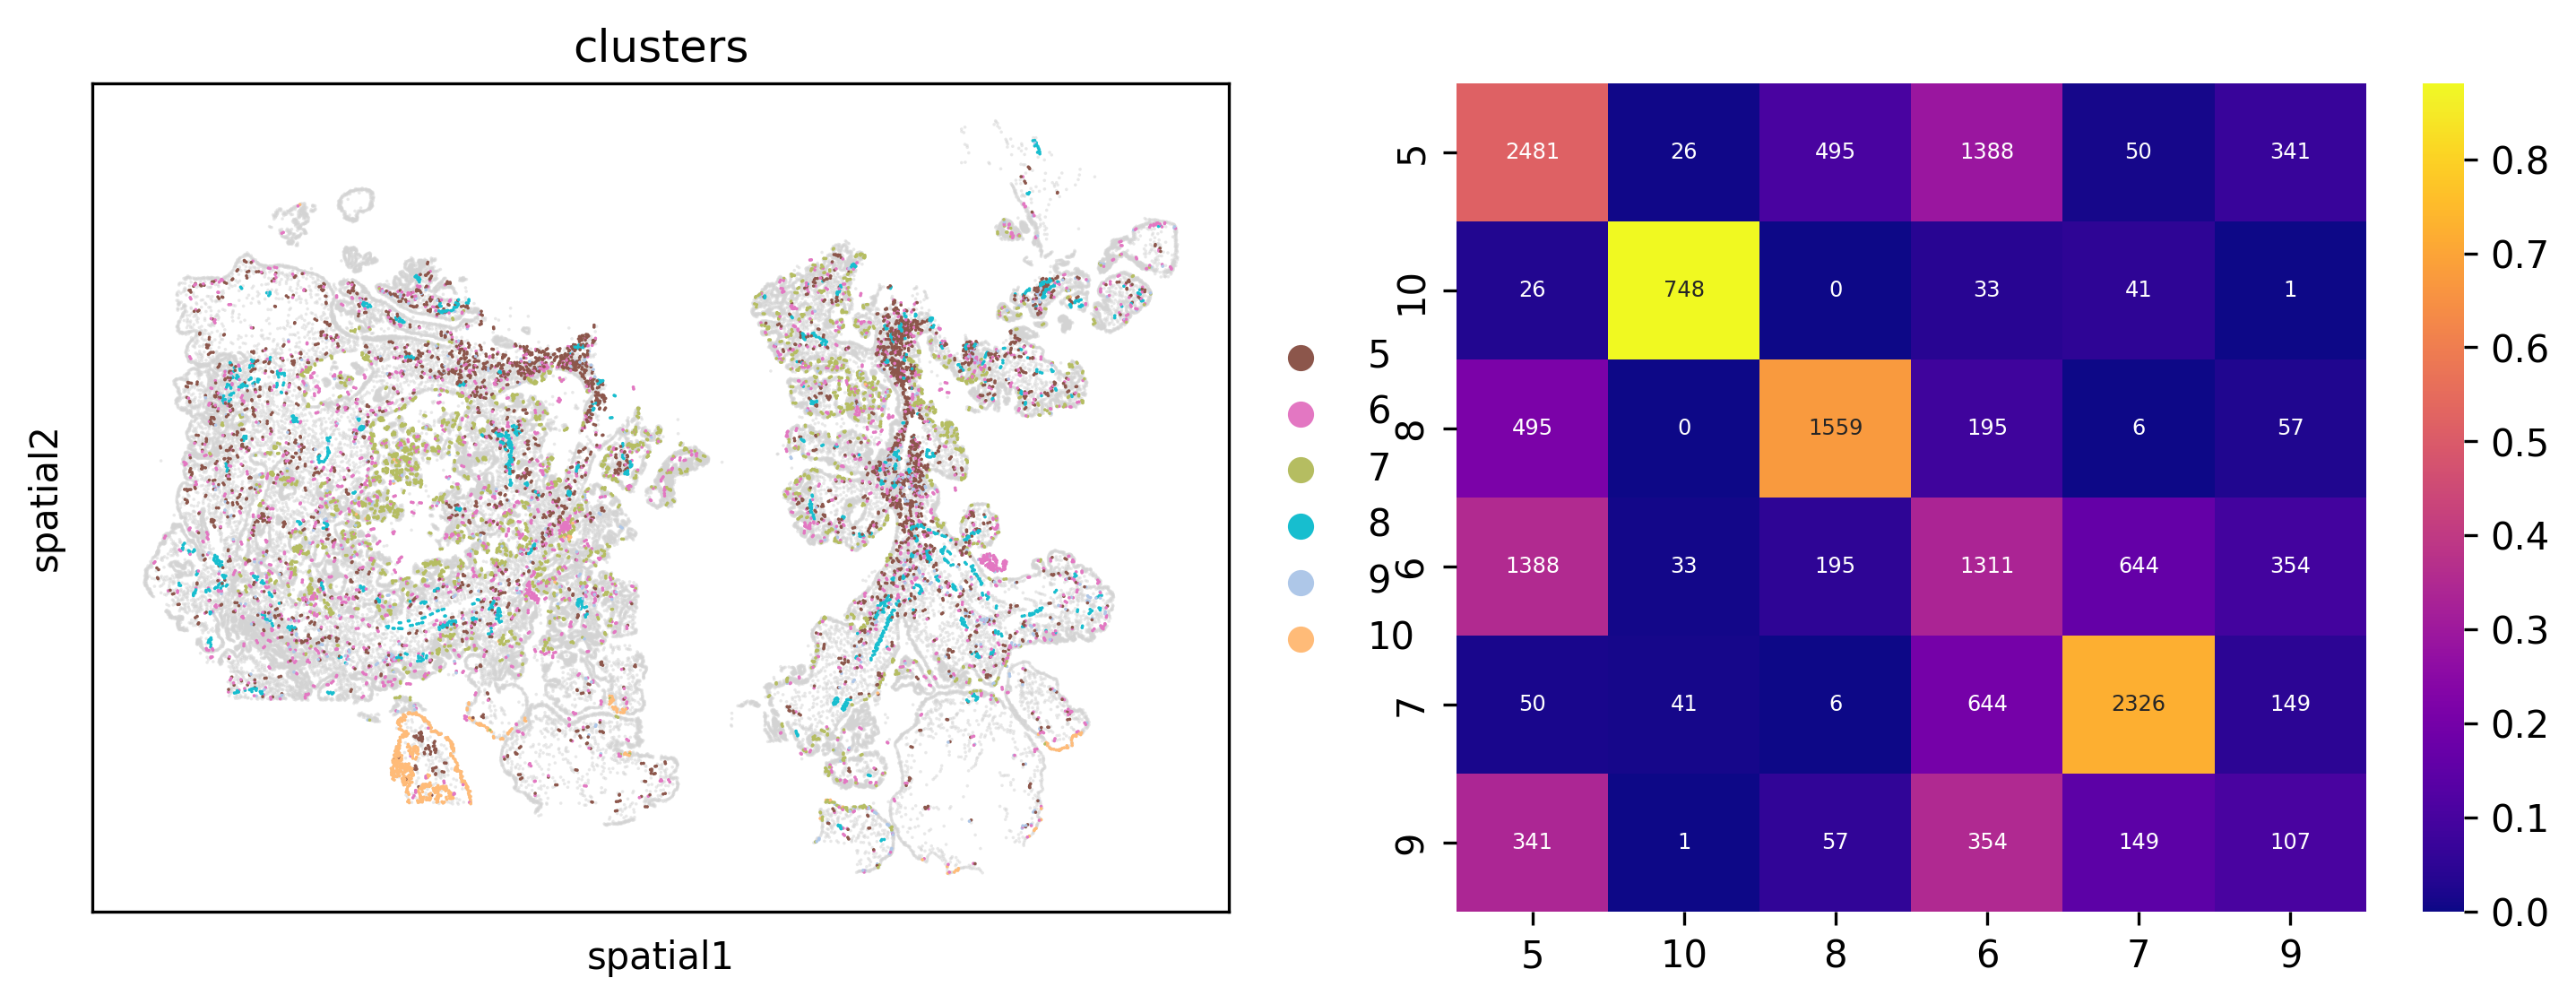

In [10]:
# Pull out clusters to examine
group1 = list(map(str, range(5, 11)))
group2 = list(map(str, range(5, 11)))

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

# Calculate cell contact in 15-micron radius between group1 and group2
observed_contacts = mb.calc.cell_contact(
    adata,
    groupby = "clusters",
    group1 = group1,
    group2 = group2,
    radius = 15
)

# Plot observed contact in color, and all cells in gray
mb.plot.cell_contact_embedding(
    adata,
    observed_contacts,
    group = "clusters",
    ax = axs[0],
    show = False,
    s = 3,
)

# Plot a heatmap showing number of contacts between each group
mb.plot.cell_contact_heatmap(
    adata,
    "clusters",
    observed_contacts,
    ax = axs[1],
    show = False,
    annot_kws = {
        "fontsize": "xx-small"
    }
)
plt.gcf().set_dpi(300)
plt.show()

Monkeybread also implements a permutation test to test whether the number of cells in contact between two groups is greater than what we would expect by chance. For each cell, we permute the x-y coordinates within a fixed radius of the cell. We then re-calculate the number of cells in contact. A p-value is returned representing the fraction of permuted samples with contact frequencies greater than the observed contact frequencies. The vertical red line below depicts the observed frequencies.

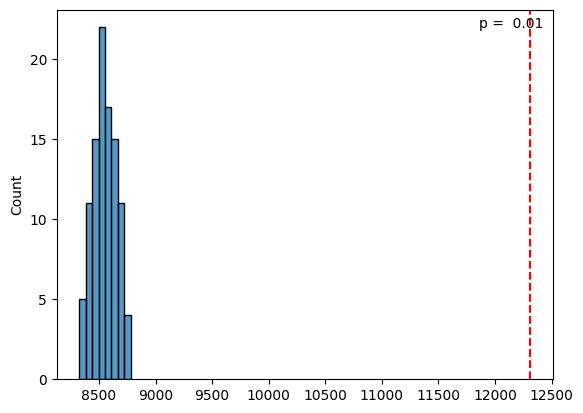

In [11]:
permutation_contacts_grouped = mb.stat.cell_contact(
    adata,
    groupby = "clusters",
    group1 = group1,
    group2 = group2,
    actual_contact = observed_contacts,
    n_perms = 100,
    contact_radius = 15,
    perm_radius = 100
)
mb.plot.cell_contact_histplot(
    adata,
    "clusters",
    observed_contacts,
    expected_contacts = permutation_contacts_grouped,
    show = True,
)

Monkeybread enables this permutation test to be performed pairwise between two sets of groups of cells. When the `split_groups` parameter is set to `True`, contact frequency p-values are generated for all pairs of labels in group1 and group2. The cell_contact_heatmap function can be used to display these pairwise p-values.

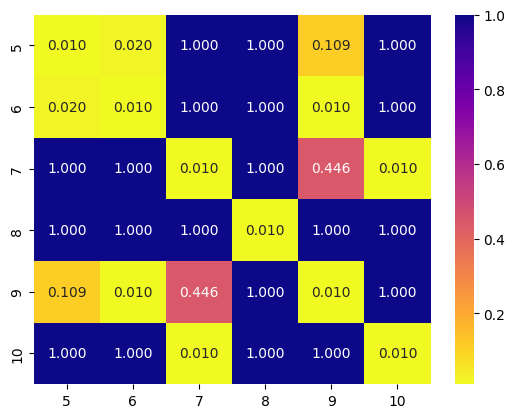

In [12]:
permutation_contacts_split = mb.stat.cell_contact(
    adata,
    groupby = "clusters",
    group1 = group1,
    group2 = group2,
    actual_contact = observed_contacts,
    n_perms = 100,
    contact_radius = 15,
    perm_radius = 100,
    split_groups = True
)
mb.plot.cell_contact_heatmap(
    adata,
    "clusters",
    observed_contacts,
    expected_contacts = permutation_contacts_split
)

DE analysis can be performed between cells in group1 that are in contact with cells in group2 versus those that are not.

In [13]:
adata.obs["touching"] = pd.Categorical([cell in observed_contacts for cell in adata.obs.index])
sc.tl.rank_genes_groups(
    adata,
    groupby = "touching",
    use_raw = False
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


Monkeybread also exposes a [volcano plot](https://en.wikipedia.org/wiki/Volcano_plot_(statistics)) function for observing results of a DE analysis.

C:\Users\Dillon Scott\monkeybread\venv\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


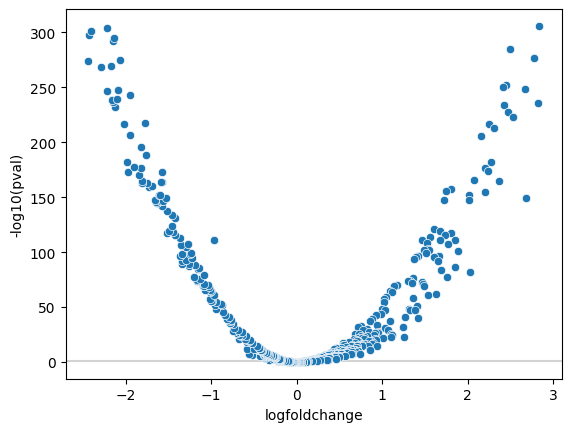

In [14]:
mb.plot.volcano_plot(
    adata,
    group = "True",
    adjusted_pvals = True,
)

### Neighborhood Profiles

Monkeybread's `neighborhood_profile` function creates a profile for each cell, utilizing the `cell_contact` function with a heightened radius. The function will detect all cells within the radius, then generate a neighborhood profile with proportions relating to the `groupby` column in `adata.obs`. This is returned in the form of a new AnnData object, where `.X` corresponds to neighborhood profile instead of gene expression profile.

In [15]:
adata_neighbors = mb.calc.neighborhood_profile(
    adata,
    groupby = "clusters",
    radius = 50,
)

Similar to gene expression profiles, neighborhood profiles can be clustered to reveal interesting niches in the spatial data.

In [16]:
sc.pp.neighbors(adata_neighbors)
sc.tl.umap(adata_neighbors)
sc.tl.leiden(adata_neighbors, key_added = "neighborhood_clusters", resolution = 0.5)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)
running Leiden clustering
    finished: found 40 clusters and added
    'neighborhood_clusters', the cluster labels (adata.obs, categorical) (0:00:07)


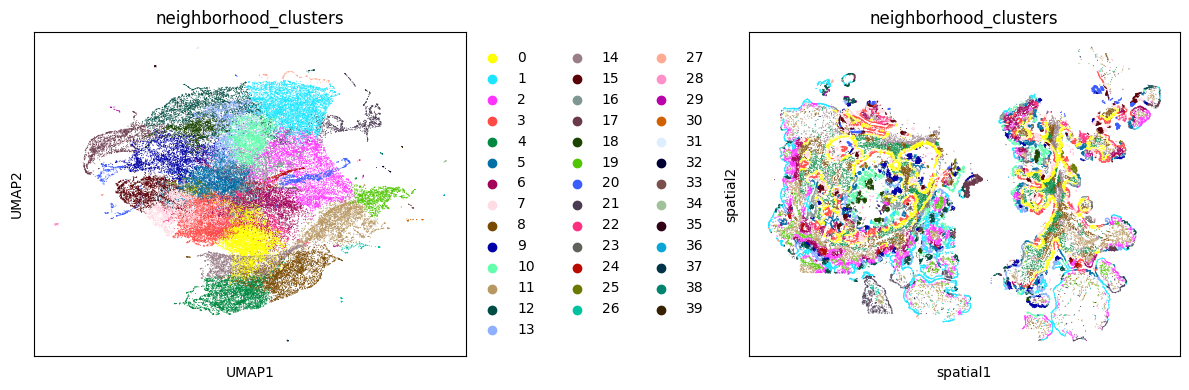

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
sc.pl.embedding(
    adata_neighbors,
    basis = "umap",
    color = "neighborhood_clusters",
    ax = axs[0],
    show = False
)
sc.pl.embedding(
    adata_neighbors,
    basis = "spatial",
    color = "neighborhood_clusters",
    ax = axs[1],
    legend_loc = None,
    show = False
)
plt.tight_layout()
plt.show()

### Cell Transcript Observations

If `detected_transcripts.csv` and `cell_boundaries/` are present in the folder loaded by `load_merscope`, you can use some additional functions to view data at the cellular and transcriptional level.

In [18]:
# Pull out some interesting cells - here we look at some cells observed to be contacting
cell_ids = [list(observed_contacts.keys())[0]]
cell_ids.extend(observed_contacts[cell_ids[0]])

# Detect transcripts in the surrounding area of the selected cells
transcript_proximity_df = mb.calc.cell_transcript_proximity(
    adata,
    cell_ids,
)

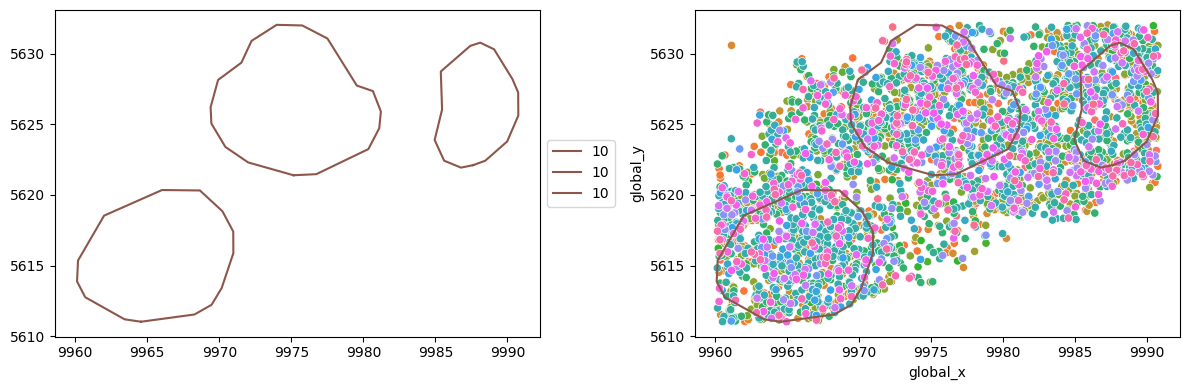

In [19]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
# Plot only the cells - no transcripts
mb.plot.cell_transcript_proximity(
    adata,
    cell_ids,
    label = "clusters",
    legend = True,
    show = False,
    ax = axs[0]
)
# Plot cells with all transcripts
mb.plot.cell_transcript_proximity(
    adata,
    cell_ids,
    transcripts = transcript_proximity_df,
    label = "clusters",
    show = False,
    ax = axs[1]
)
plt.tight_layout()
plt.show()

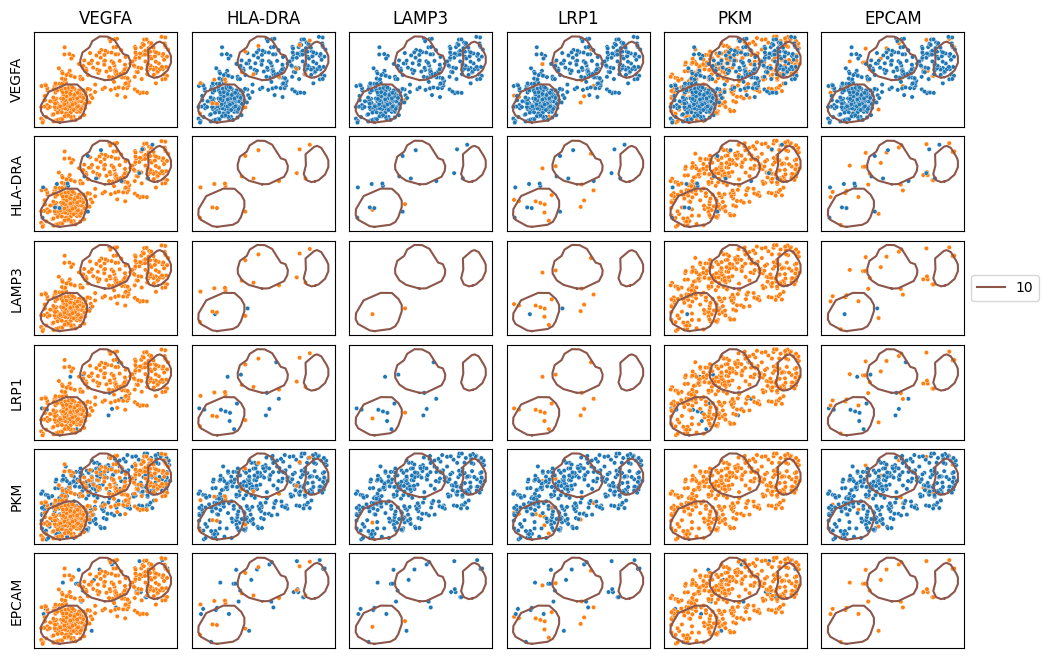

In [20]:
# Observe some transcripts of interest in a pairwise manner
# Columns are orange, rows are blue
mb.plot.cell_transcript_proximity(
    adata,
    cell_ids,
    transcript_proximity_df[transcript_proximity_df["gene"].isin(["PKM", "HLA-DRA", "VEGFA", "LRP1", "EPCAM", "LAMP3"])],
    label = "clusters",
    pairwise = True
)
plt.show()

## Other Utility Functions

Below, we demonstrate a function that subsets an AnnData object based on spatial location and/or gene counts. When subsetting by spatial location, this allows for “zooming in” on portions of the dataset.

In [21]:
adata_zoomed = mb.util.subset_cells(
    adata,
    by = "spatial",
    subset = [
        ("x", "lte", 10000),
        ("x", "gte", 9000),
        ("y", "lte", 8000),
        ("y", "gte", 7000)
    ]
)

You can then perform any other analyses using the new `adata` object.

In [22]:
zoomed_contact = mb.calc.cell_contact(
    adata_zoomed,
    groupby = "clusters",
    group1 = group1,
    group2 = group2,
)

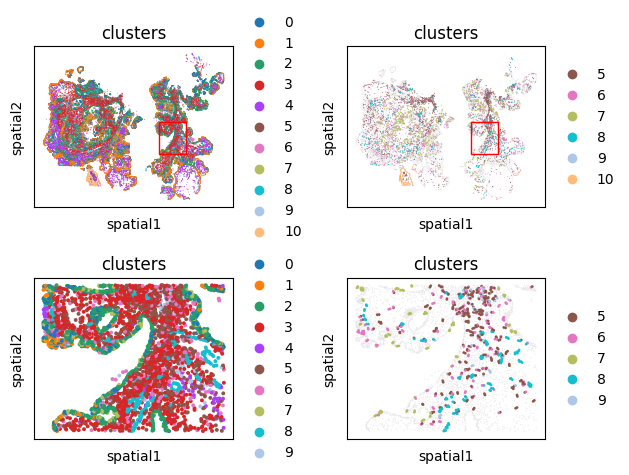

In [23]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)
sc.pl.embedding(
    adata,
    basis = "spatial",
    color = "clusters",
    ax = axs[0][0],
    show = False,
)
rect = mpl.patches.Rectangle((9000, 7000), 1000, 1000, linewidth=1, edgecolor='r', facecolor='none')
axs[0][0].add_patch(rect)
mb.plot.cell_contact_embedding(
    adata,
    observed_contacts,
    group = "clusters",
    ax = axs[0][1],
    show = False
)
rect = mpl.patches.Rectangle((9000, 7000), 1000, 1000, linewidth=1, edgecolor='r', facecolor='none')
axs[0][1].add_patch(rect)
sc.pl.embedding(
    adata_zoomed,
    basis = "spatial",
    color = "clusters",
    ax = axs[1][0],
    show = False,
)
mb.plot.cell_contact_embedding(
    adata_zoomed,
    zoomed_contact,
    group = "clusters",
    ax = axs[1][1],
    show = False
)
plt.tight_layout()
plt.show()